## Chapter 9: Ensemble methods and Qboost

Import packages 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.metrics
%matplotlib inline

metric = sklearn.metrics.accuracy_score

Generate a random dataset of two classes that form concentric circles:

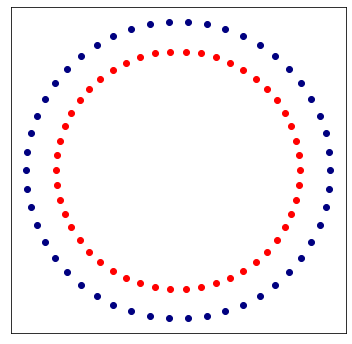

In [19]:
np.random.seed(0)
data, labels = sklearn.datasets.make_circles()
idx = np.arange(len(labels))
np.random.shuffle(idx)
# train on a random 2/3 and test on the remaining 1/3
idx_train = idx[:2*len(idx)//3]
idx_test = idx[2*len(idx)//3:]
X_train = data[idx_train]
X_test = data[idx_test]

y_train = 2 * labels[idx_train] - 1  # binary -> spin
y_test = 2 * labels[idx_test] - 1

scaler = sklearn.preprocessing.StandardScaler()
normalizer = sklearn.preprocessing.Normalizer()

X_train = scaler.fit_transform(X_train)
X_train = normalizer.fit_transform(X_train)

X_test = scaler.fit_transform(X_test)
X_test = normalizer.fit_transform(X_test)
plt.figure(figsize=(6, 6))
plt.subplot(111, xticks=[], yticks=[])
plt.scatter(data[labels == 0, 0], data[labels == 0, 1], color='navy')
plt.scatter(data[labels == 1, 0], data[labels == 1, 1], color='red');

Train a perceptron:

In [3]:
from sklearn.linear_model import Perceptron
model_1 = Perceptron()
model_1.fit(X_train, y_train)
print('accuracy (train): %5.2f'%(metric(y_train, model_1.predict(X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, model_1.predict(X_test))))

accuracy (train):  0.44
accuracy (test):  0.65


In [4]:
from sklearn.svm import SVC
model_2 = SVC(kernel='rbf')
model_2.fit(X_train, y_train)
print('accuracy (train): %5.2f'%(metric(y_train, model_2.predict(X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, model_2.predict(X_test))))

accuracy (train):  0.62
accuracy (test):  0.24


In [5]:
from sklearn.ensemble import AdaBoostClassifier
model_3 = AdaBoostClassifier(n_estimators=3)
model_3.fit(X_train, y_train)
print('accuracy (train): %5.2f'%(metric(y_train, model_3.predict(X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, model_3.predict(X_test))))

accuracy (train):  0.65
accuracy (test):  0.29


Its performance is marginally better than that of the SVM.

In [6]:
models = [model_1, model_2, model_3]

In [7]:
n_models = len(models)

predictions = np.array([h.predict(X_train) for h in models], dtype=np.float64)
# scale hij to [-1/N, 1/N]
predictions *= 1/n_models

λ = 1

Create the quadratic binary optimization of the objective function as we expanded above:

In [8]:
w = np.dot(predictions, predictions.T)
wii = len(X_train) / (n_models ** 2) + λ - 2 * np.dot(predictions, y_train)
w[np.diag_indices_from(w)] = wii
W = {}
for i in range(n_models):
    for j in range(i, n_models):
        W[(i, j)] = w[i, j]

Solve the quadratic binary optimization with simulated annealing and read out the optimal weights:

In [9]:
import dimod
sampler = dimod.SimulatedAnnealingSampler()
response = sampler.sample_qubo(W, num_reads=10)
weights = list(response.first.sample.values())

Define a prediction function to help with measuring accuracy:

In [10]:
def predict(models, weights, X):

    n_data = len(X)
    T = 0
    y = np.zeros(n_data)
    for i, h in enumerate(models):
        y0 = weights[i] * h.predict(X)  # prediction of weak classifier
        y += y0
        T += np.sum(y0)

    y = np.sign(y - T / (n_data*len(models)))

    return y

In [11]:
print('accuracy (train): %5.2f'%(metric(y_train, predict(models, weights, X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, predict(models, weights, X_test))))

accuracy (train):  0.65
accuracy (test):  0.29


In [12]:
weights

[0, 0, 1]